# Prelude 

In [1]:
from landau.phases import LinePhase, IdealSolution
from landau.calculate import calc_phase_diagram
from landau.plot import plot_phase_diagram, plot_1d_T_phase_diagram, plot_1d_mu_phase_diagram, plot_mu_phase_diagram

In [2]:
import numpy as np
from scipy.constants import Boltzmann, eV
kB = Boltzmann/eV

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Phases Setup

Same phase setup as in `IdealSolution.ipynb`.  Energies and entropies are picked manually to make simple examples.

In [4]:
solid_a = LinePhase('A', fixed_concentration=0, line_energy=-2.0, line_entropy=1.0*kB)
solid_b = LinePhase('B', fixed_concentration=1, line_energy=-3.0, line_entropy=1.5*kB)

In [5]:
solid = IdealSolution('solid', solid_a, solid_b)

In [6]:
liquid_a = LinePhase('A(l)', fixed_concentration=0, line_energy=-1.9, line_entropy=2.5*kB)
liquid_b = LinePhase('B(l)', fixed_concentration=1, line_energy=-2.9, line_entropy=2.2*kB)

In [7]:
liquid = IdealSolution('liquid', liquid_a, liquid_b)

In [8]:
inter = LinePhase('AB$_2$', fixed_concentration=2/3, line_energy=-2.8, line_entropy=1.3*kB)

In [9]:
df = calc_phase_diagram([solid, liquid, inter], Ts=np.linspace(1, 2000, 100), mu=200, keep_unstable=True)

In [10]:
import landau.poly as lp

CPU times: user 5.36 s, sys: 89.3 ms, total: 5.44 s
Wall time: 3.65 s


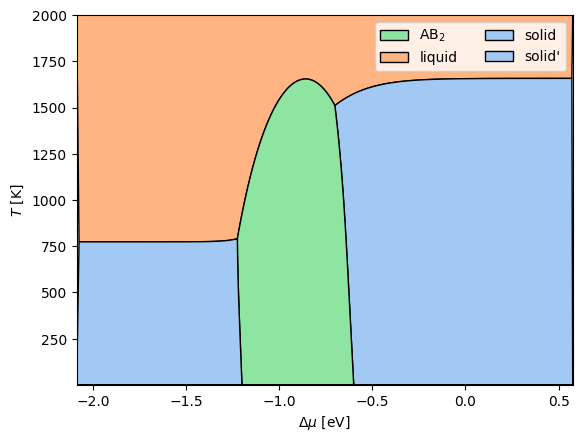

In [11]:
%%time
plot_mu_phase_diagram(df, poly_method=lp.FastTsp(duration_seconds=1))

CPU times: user 4.5 s, sys: 3.05 ms, total: 4.51 s
Wall time: 3.48 s


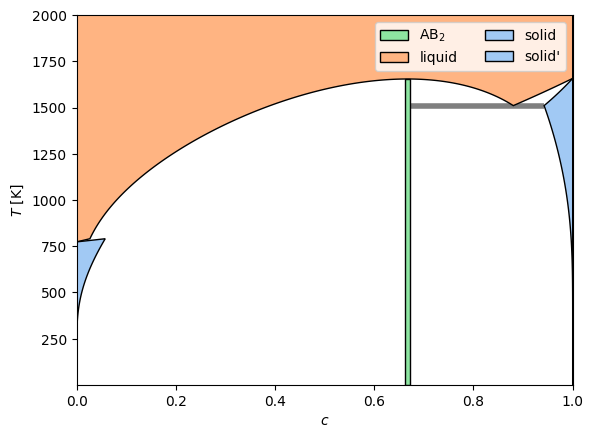

In [12]:
%%time
plot_phase_diagram(df, tielines=True)

## Zoom on Invariant Reactions

In [13]:
df = calc_phase_diagram([solid, liquid, inter], Ts=np.linspace(700, 900, 100), mu=200, keep_unstable=True)

CPU times: user 1.59 s, sys: 2.98 ms, total: 1.6 s
Wall time: 1.6 s


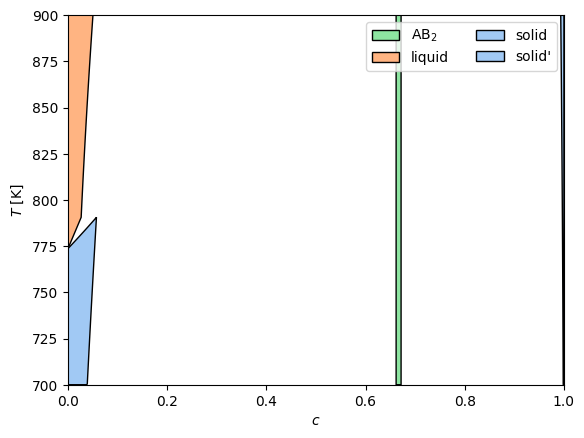

In [14]:
%%time
plot_phase_diagram(df, tielines=True)

In [15]:
df = calc_phase_diagram([solid, liquid, inter], Ts=np.linspace(1450, 1750, 100), mu=200, keep_unstable=True)

CPU times: user 3.37 s, sys: 4.1 ms, total: 3.37 s
Wall time: 2.52 s


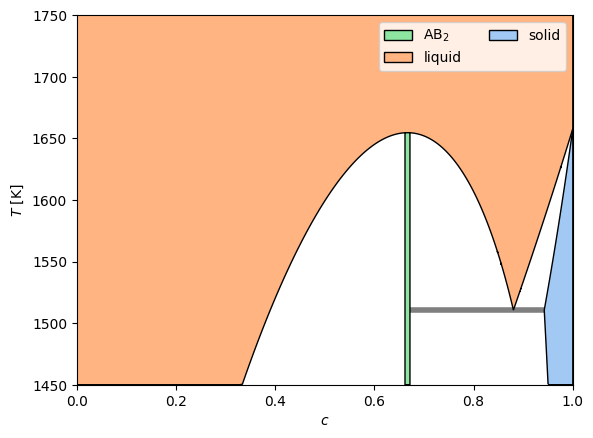

In [16]:
%%time
plot_phase_diagram(df, tielines=True)

# Congruent Melting of Intermetallic Phase

In general, the phase boundaries in a phase diagram demark where the semi-grand potentials are equal across phases.
For intermetallics with neglible solubility, we can follow the isopotential lines along temperature to find the exact melting point.
landau does this implicitly when calculating the full phase diagram, but we can follow along temperature only, if we print the equilibrium chemical potential from the full calculation above and then recalculate the equilibria at that potential.

In [17]:
ab = df.query('border and phase == "AB$_2$"')
ab.loc[ab['T'].idxmax(),['mu', 'T']]

mu      -0.857277
T     1654.559173
Name: 60947, dtype: object

In [18]:
df = calc_phase_diagram([solid, liquid, inter], Ts=np.linspace(1500, 1800, 100), mu=-0.858751, keep_unstable=True)

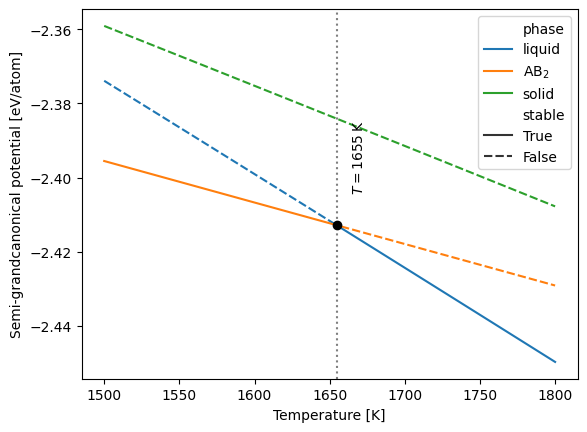

<Axes: xlabel='Temperature [K]', ylabel='Semi-grandcanonical potential [eV/atom]'>

In [19]:
plot_1d_T_phase_diagram(df)

# Double Tangent Construction and Free Energies of Formation

`landau` works entirely in chemical potential space, but the equivalent double tangent constructions can be reconstructed from the dataframes returned from `calc_phase_diagram`.
The example below first calculates three isothermal sections of the phase diagram

In [20]:
import pandas as pd

In [21]:
df = pd.concat([
    calc_phase_diagram([solid, liquid, inter], Ts=T, mu=100, keep_unstable=True)
        for T in [500, 1000, 1600]
], ignore_index=True)

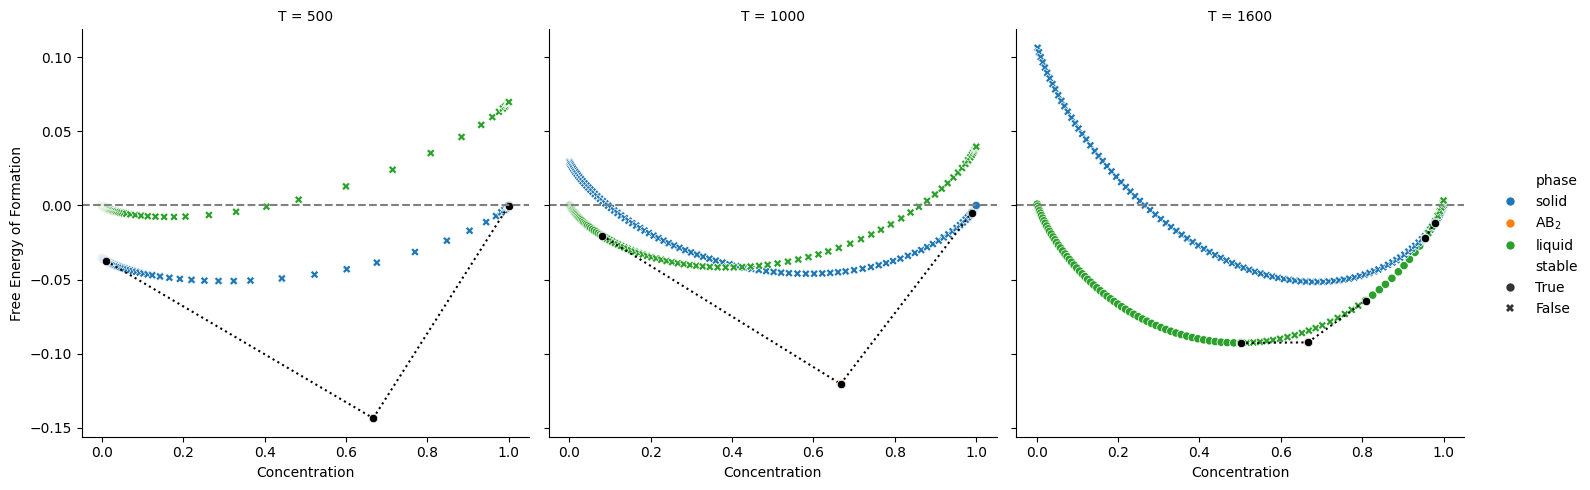

In [22]:
g = sns.relplot(
    data=df,
    x='c', y='f_excess',
    hue='phase',
    col='T',
    style='stable', style_order=[True, False]
).map_dataframe(
    lambda data, *a, **kw: sns.lineplot(data.query('border'), *a, **kw),
    x='c', y='f_excess',
    ls='dotted', 
    units='mu', estimator=None,
    color='k',
).map_dataframe(
    lambda data, *a, **kw: sns.scatterplot(data.query('border'), *a, **kw),
    x='c', y='f_excess',
    color='k',
    zorder=2,
).refline(
    y=0
).set(
    xlabel='Concentration',
    ylabel='Free Energy of Formation',
)